# Проект: Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, необходимо спрогнозировать количество заказов такси на следующий час. Надо создать модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

<h1>Содержание

<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li></ul></div>

## Вывод:

<div class="alert alert-block alert-info">
На переборе параметров лучшее значение метрики у модели CatBoostRegressor() со значением метрики на тестовой выборке RMSE - 45,93.
        </div>

## Подготовка

In [1]:
pip install catboost

Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np 
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
import lightgbm as lgb
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
import time
import warnings
from sklearn.model_selection import cross_validate
warnings.filterwarnings('ignore')
RND = 12345

In [2]:
data = pd.read_csv('taxi.csv',parse_dates =[0])

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


In [4]:
data['datetime'] = pd.to_datetime(data['datetime'])

In [5]:
data = data.set_index('datetime')

Отсортирую даты в порядке возрастания

In [6]:
data = data.sort_index()

Если порядок соблюдён, атрибут вернёт True, если нет — False.

In [7]:
data.index.is_monotonic

True

Изучу данные

In [8]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [9]:
data.isna().sum()

num_orders    0
dtype: int64

Данные идут с периодичностью в 10 минут. По условиям задачи нужно выполнить ресемплирование по 1 часу.

In [10]:
data = data.resample('1H').sum()

<b> Данные готовы к анализу

## Анализ

<AxesSubplot:xlabel='datetime'>

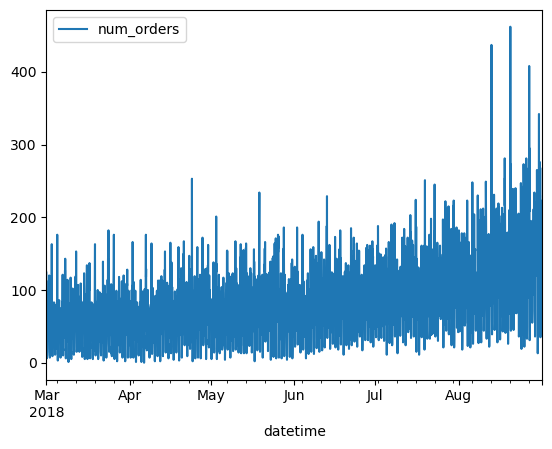

In [11]:
data.plot()

In [12]:
data_new = data-data.shift()

<AxesSubplot:xlabel='datetime'>

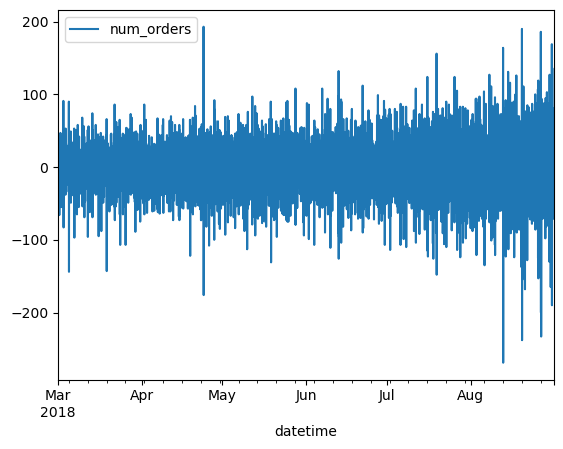

In [13]:
data_new.plot()

Выборка выглядит стационарной. Видно, что в августе происходят изменения. Изучу подробнее.

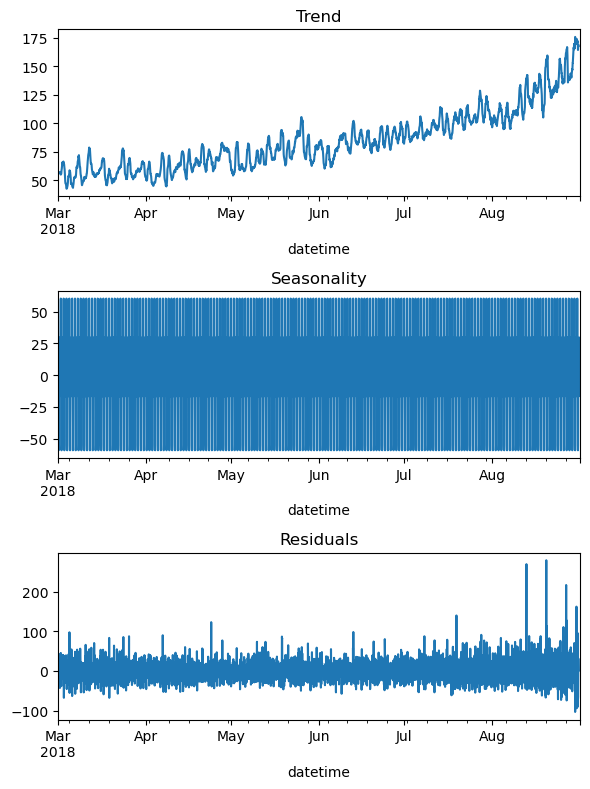

In [14]:
decomposed = seasonal_decompose(data)

plt.figure(figsize=(6, 8))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals')
plt.tight_layout()

<b> Похоже, что тренд к повышению спроса.

## Обучение

In [15]:
def make_features(data, max_lag, rolling_mean_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    
    
    data.dropna()

In [16]:
make_features(data, 10, 10)

Разделяю данные на тренировочную и тестовую выборки. Тестовая 10% от исходных данных

In [17]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()
test = test.dropna()
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

In [18]:
def train_rmse(model, title):
    model = model
    model.fit(features_train, target_train)
    train_pred = model.predict(features_train)
    test_pred = model.predict(features_test)
    print(title)
    print("RMSE обучающей выборки:", mean_squared_error(target_train, train_pred)**0.5)
    print("RMSE тестовой выборки: ", mean_squared_error(target_test, test_pred)**0.5)

<b> Данные готовы для тестировнаия

## Тестирование

<b> LinearRegression

In [20]:
%%time
train_rmse(LinearRegression(), 'LinearRegression')

LinearRegression
RMSE обучающей выборки: 30.227478972830003
RMSE тестовой выборки:  53.454643856732524
Wall time: 48.1 ms


<b> RandomForestRegressor

In [21]:
%%time
train_rmse(RandomForestRegressor(), 'RandomForestRegressor')

RandomForestRegressor
RMSE обучающей выборки: 8.465294132083313
RMSE тестовой выборки:  44.08813296484431
Wall time: 4.51 s


<b> LGBMRegressor

In [22]:
%%time
train_rmse(LGBMRegressor(), 'LGBMRegressor')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000855 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2225
[LightGBM] [Info] Number of data points in the train set: 3964, number of used features: 15
[LightGBM] [Info] Start training from score 78.355701
LGBMRegressor
RMSE обучающей выборки: 13.76656202370298
RMSE тестовой выборки:  42.46268363530078
Wall time: 424 ms


<b> CatBoostRegressor

In [23]:
%%time
train_rmse(CatBoostRegressor(), 'CatBoostRegressor')

Learning rate set to 0.050896
0:	learn: 37.7819767	total: 60.3ms	remaining: 1m
1:	learn: 36.8701426	total: 65.4ms	remaining: 32.6s
2:	learn: 36.2218361	total: 71.1ms	remaining: 23.6s
3:	learn: 35.3912113	total: 76.6ms	remaining: 19.1s
4:	learn: 34.6411437	total: 83ms	remaining: 16.5s
5:	learn: 33.9681767	total: 88.8ms	remaining: 14.7s
6:	learn: 33.3263635	total: 93.9ms	remaining: 13.3s
7:	learn: 32.7690450	total: 99.5ms	remaining: 12.3s
8:	learn: 32.2520705	total: 104ms	remaining: 11.5s
9:	learn: 31.7222201	total: 109ms	remaining: 10.8s
10:	learn: 31.1788722	total: 115ms	remaining: 10.3s
11:	learn: 30.6917293	total: 120ms	remaining: 9.89s
12:	learn: 30.2585325	total: 125ms	remaining: 9.49s
13:	learn: 29.8922057	total: 130ms	remaining: 9.18s
14:	learn: 29.5004648	total: 135ms	remaining: 8.89s
15:	learn: 29.1030442	total: 140ms	remaining: 8.62s
16:	learn: 28.7568163	total: 146ms	remaining: 8.43s
17:	learn: 28.4696073	total: 151ms	remaining: 8.22s
18:	learn: 28.1648741	total: 156ms	remain

<b> XGBRegressor

In [24]:
%%time
train_rmse(XGBRegressor(), 'XGBRegressor')

XGBRegressor
RMSE обучающей выборки: 5.848860922602405
RMSE тестовой выборки:  46.95044606810555
Wall time: 762 ms


_Согласно задания модели нужно обучать с различными гиперпараметрами. Подберу гиперпараметры к моделям._

In [25]:
splits = TimeSeriesSplit(n_splits=3)

<b> LinearRegression

In [26]:


%%time
Line_params = {'fit_intercept':[True,False], 'copy_X':[True, False]}

Line_grid = GridSearchCV(LinearRegression(), param_grid = Line_params, refit=False, scoring='neg_mean_squared_error', cv=splits)
Line_m = Line_grid.fit(features_train, target_train)
print(f'Лучшая RMSE: {-Line_m.best_score_} при параметрах {Line_m.best_params_}')

Лучшая RMSE: 1053.2469831052856 при параметрах {'copy_X': True, 'fit_intercept': False}
Wall time: 189 ms


In [27]:

RSME_Line = -cross_val_score(LinearRegression(), features_train, target_train, scoring='neg_root_mean_squared_error', cv=splits).mean()
print(RSME_Line)

32.46468466326402


<b> RandomForestRegressor

In [28]:
%%time
RFR_params = {
       
        'max_depth' : range(5, 15, 2),
        'verbose' : [0],
        'random_state' : [RND]
       }

RFR_grid = GridSearchCV(RandomForestRegressor(), param_grid = RFR_params, refit=False, scoring='neg_mean_squared_error', cv=splits)
RFR_m = RFR_grid.fit(features_train, target_train)
print(f'Лучшая RMSE: {-RFR_m.best_score_} при параметрах {RFR_m.best_params_}')

Лучшая RMSE: 745.2039150337314 при параметрах {'max_depth': 13, 'random_state': 12345, 'verbose': 0}
Wall time: 19.3 s


In [29]:

RSME_RFR = -cross_val_score(RandomForestRegressor(), features_train, target_train, scoring='neg_root_mean_squared_error', cv=splits).mean()
print(RSME_RFR)

27.036244266728502


<b> LGBMRegressor

In [30]:
%%time
lgb_params = {
        'n_estimators' : range(50, 100, 10),
        'max_depth' : range(5, 15, 2),
        'verbose' : [0],
        'random_state' : [RND],
        
        }

lgb_grid = GridSearchCV(LGBMRegressor(), param_grid = lgb_params, refit=False, scoring='neg_mean_squared_error', cv=splits)
lgb_m = lgb_grid.fit(features_train, target_train)


print(f'Лучшая RMSE: {-lgb_m.best_score_} при параметрах {lgb_m.best_params_}')

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

In [31]:
RSME_lgb = -cross_val_score(LGBMRegressor(), features_train, target_train, scoring='neg_root_mean_squared_error', cv=splits).mean()
print(RSME_lgb)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000881 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1457
[LightGBM] [Info] Number of data points in the train set: 991, number of used features: 15
[LightGBM] [Info] Start training from score 57.172553
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000242 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1750
[LightGBM] [Info] Number of data points in the train set: 1982, number of used features: 15
[LightGBM] [Info] Start training from score 63.324924
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000138 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1970
[LightGBM] [Info] Number of data points in the train set:

<b> CatBoostRegressor

In [33]:
%%time
cat_params = {
            'n_estimators' : [50, 100],
            'verbose' : [0],
            'random_state' : [RND],
            'max_depth' : [5, 7, 10]
             }
cat_grid = GridSearchCV(CatBoostRegressor(), param_grid = cat_params, refit=False, scoring='neg_mean_squared_error', cv=splits)
cat_m = cat_grid.fit(features_train, target_train)
print(f'Лучшая RMSE: {-cat_m.best_score_} при параметрах {cat_m.best_params_}')


Лучшая RMSE: 745.7027085004314 при параметрах {'max_depth': 5, 'n_estimators': 100, 'random_state': 12345, 'verbose': 0}
Wall time: 36.6 s


In [34]:
RSME_cat = -cross_val_score(CatBoostRegressor(), features_train, target_train, scoring='neg_root_mean_squared_error', cv=splits).mean()
print(RSME_cat)

Learning rate set to 0.040885
0:	learn: 28.7381696	total: 5.54ms	remaining: 5.54s
1:	learn: 28.2475782	total: 9.88ms	remaining: 4.93s
2:	learn: 27.7462874	total: 14.7ms	remaining: 4.88s
3:	learn: 27.3201913	total: 23.4ms	remaining: 5.83s
4:	learn: 26.8789183	total: 30.9ms	remaining: 6.15s
5:	learn: 26.4318910	total: 37.3ms	remaining: 6.18s
6:	learn: 26.0004881	total: 42.7ms	remaining: 6.05s
7:	learn: 25.6487458	total: 50.7ms	remaining: 6.28s
8:	learn: 25.3169816	total: 55.8ms	remaining: 6.14s
9:	learn: 25.0973542	total: 62.8ms	remaining: 6.22s
10:	learn: 24.7448939	total: 69.4ms	remaining: 6.24s
11:	learn: 24.4022242	total: 76.9ms	remaining: 6.33s
12:	learn: 24.1831937	total: 80.6ms	remaining: 6.12s
13:	learn: 23.8643736	total: 84.7ms	remaining: 5.96s
14:	learn: 23.5866477	total: 89ms	remaining: 5.85s
15:	learn: 23.2765612	total: 93.7ms	remaining: 5.76s
16:	learn: 23.0536895	total: 96.9ms	remaining: 5.6s
17:	learn: 22.8079725	total: 100ms	remaining: 5.45s
18:	learn: 22.6311796	total: 1

<b> XGBRegressor

In [35]:
%%time
XGB_params = {
            'n_estimators' : [50, 100],
            'verbose' : [0],
            'random_state' : [RND],
            'max_depth' : [5, 7, 10]
             }
XGB_grid = GridSearchCV(XGBRegressor(), param_grid = XGB_params, refit=False, scoring='neg_mean_squared_error', cv=splits)
XGB_m = XGB_grid.fit(features_train, target_train)

print(f'Лучшая RMSE: {-lgb_m.best_score_} при параметрах {lgb_m.best_params_}')


Лучшая RMSE: 718.8010388830802 при параметрах {'max_depth': 11, 'n_estimators': 60, 'random_state': 12345, 'verbose': 0}
Wall time: 10.6 s


In [36]:
RSME_XGB = -cross_val_score(XGBRegressor(), features_train, target_train, scoring='neg_root_mean_squared_error', cv=splits).mean()
print(RSME_XGB)

27.928185512733336


<b> На переборе параметров лучшее значение метрики у модели CatBoostRegressor со значением на метрики RMSE - 26,558 Проверю модель на тестовой выборке.

In [37]:
cat_best_params = cat_grid.best_params_
cat_m = CatBoostRegressor(**cat_best_params)
cat_m.fit(features_train, target_train)
    
cat_test_pred = cat_m.predict(features_test)

print('Лучшие гиперпараметры: ', cat_best_params)
print("RMSE тестовой выборки: ", mean_squared_error(target_test, cat_test_pred)**0.5)

Лучшие гиперпараметры:  {'max_depth': 5, 'n_estimators': 100, 'random_state': 12345, 'verbose': 0}
RMSE тестовой выборки:  45.93255937786332


# Вывод:
<b> На переборе параметров лучшее значение метрики у модели CatBoostRegressor() со значением метрики на тестовой выборке RMSE - 45,93.